In [1]:
#U-net image segmentation
import os
import random
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.exposure import equalize_adapthist

In [2]:
def normalize(img):
    img_cop  = img.copy()
    img_cop  = img_cop.astype('float64') 
    img_min  = np.min(img_cop)
    img_max  = np.max(img_cop)
    img_cop  = (img_cop - img_min)/(img_max - img_min)
    return img_cop

def save(filename, *args):
    # Get global dictionary
    glob = globals()
    d = {}
    for v in args:
        # Copy over desired values
        d[v] = glob[v]
    with open(filename, 'wb') as f:
        # Put them in the file 
        pickle.dump(d, f)

In [3]:
images_path = 'images/'
masks_path  = 'masks/'

In [4]:
images_paths = sorted(
    [os.path.join(images_path, fname)
     for fname in os.listdir(images_path)
     if fname.endswith(".png")]
)

masks_paths = sorted(
    [os.path.join(masks_path, fname)
     for fname in os.listdir(masks_path)
     if fname.endswith(".png") and not fname.startswith(".")]
)

random.Random(1337).shuffle(images_paths)
random.Random(1337).shuffle(masks_paths)
train_images_paths = images_paths
train_masks_paths  = masks_paths

img_height    = 256
img_width     = 256
img_channels  = 3

In [5]:
X_train = np.zeros((len(train_images_paths), img_height, img_width, img_channels), dtype= 'uint8')
Y_train = np.zeros((len(train_masks_paths), img_height, img_width, 1), dtype = np.bool_)

for i in range(len(train_images_paths)):   
    img = imread(train_images_paths[i])[:,:,:img_channels] 
    img = np.around(255*normalize(img)).astype('uint8')
    X_train[i] = img  #Fill empty X_train with values from img
    
for i in range(len(train_masks_paths)):   
    img = np.mean(imread(train_masks_paths[i]), 2)
    img = 1.0 * (img > 80)
    img = np.expand_dims(img, axis=2)
    Y_train[i] = img  #Fill empty Y_train with values from img 

print(X_train.shape)

In [6]:
#Build the model
inputs = tf.keras.layers.Input((img_height, img_width, img_channels))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='mean_square_error', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                              

In [64]:
#callbacks
callbacks = [tf.keras.callbacks.EarlyStopping(patience  = 2,
                                              monitor   = 'val_loss', 
                                              min_delta = 1e-4),
             tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train,
                    validation_split = 0.1,
                    batch_size       = 64,
                    epochs           = 20,
                    callbacks        = callbacks)

Epoch 1/20
1/1 [==============================] - 11s 11s/step - loss: 0.1482 - accuracy: 0.9343 - val_loss: 0.3158 - val_accuracy: 0.8869
Epoch 2/20
1/1 [==============================] - 11s 11s/step - loss: 0.1482 - accuracy: 0.9344 - val_loss: 0.3128 - val_accuracy: 0.8866
Epoch 3/20
1/1 [==============================] - 11s 11s/step - loss: 0.1467 - accuracy: 0.9349 - val_loss: 0.3109 - val_accuracy: 0.8865
Epoch 4/20
1/1 [==============================] - 11s 11s/step - loss: 0.1467 - accuracy: 0.9349 - val_loss: 0.3111 - val_accuracy: 0.8865
Epoch 5/20
1/1 [==============================] - 11s 11s/step - loss: 0.1476 - accuracy: 0.9341 - val_loss: 0.3127 - val_accuracy: 0.8868


In [62]:
model.save('model_segmentation') 

INFO:tensorflow:Assets written to: model_segmentation\assets


INFO:tensorflow:Assets written to: model_segmentation\assets


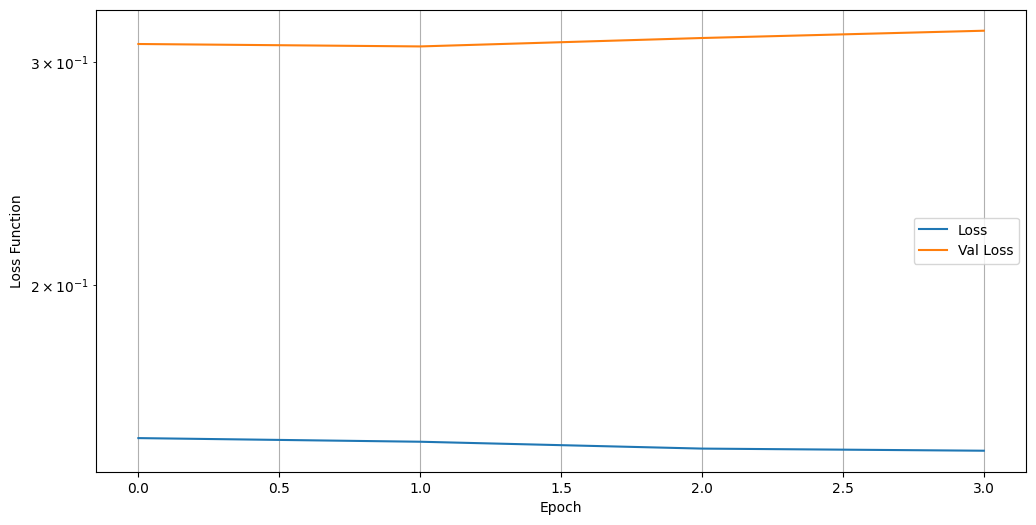

In [63]:
plt.figure(figsize=(12,6))
plt.semilogy(results.history['loss'], label = 'Loss')
plt.semilogy(results.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.legend()
plt.grid('on')
plt.show()